# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [1]:
!git clone https://github.com/sim0nsays/dlcourse_ai.git
!cp dlcourse_ai/assignments/assignment2/*.py .
!./dlcourse_ai/assignments/assignment2/download_data.sh

Cloning into 'dlcourse_ai'...
remote: Enumerating objects: 357, done.
remote: Total 357 (delta 0), reused 0 (delta 0), pack-reused 357
Receiving objects: 100% (357/357), 740.01 KiB | 11.38 MiB/s, done.
Resolving deltas: 100% (165/165), done.
--2021-03-08 07:40:45--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  18.6MB/s    in 13s     

2021-03-08 07:40:58 (13.4 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2021-03-08 07:40:58--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Reusing existing connection to ufldl.stanford.edu:80.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [3]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [4]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [ ]:
a = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])
a = np.where(a > 0, a, 0)
print(a)
print(np.int64(a > 0))


[[1.  0.  3. ]
 [0.  2.  0.1]]
[[1 0 1]
 [0 1 1]]


In [6]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [7]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [8]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for hidden_W
Gradient check passed!
Checking gradient for fully_connected_W
Gradient check passed!
Checking gradient for hidden_B
Gradient check passed!
Checking gradient for fully_connected_B
Gradient check passed!


True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [9]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for hidden_W
Gradient check passed!
Checking gradient for fully_connected_W
Gradient check passed!
Checking gradient for hidden_B
Gradient check passed!
Checking gradient for fully_connected_B
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [10]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
print(model_with_reg.predict(train_X[:30]).shape)
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

(30,)


0.03333333333333333

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [15]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 10, reg = 1e1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-2)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Loss: 2.301901, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301250, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301903, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.303973, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 2.301728, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302833, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302302, Train accuracy: 0.196667, val accuracy: 0.206000


KeyboardInterrupt: ignored

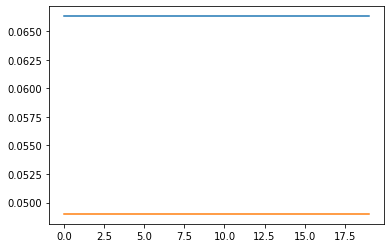

In [ ]:
plt.plot(train_history)
plt.plot(val_history)

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [ ]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Loss: 2.297637, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.276159, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.269356, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.263773, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.222528, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.250457, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.237240, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.363020, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.232430, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.345336, Train accuracy: 0.196667, val accuracy: 0.206000


KeyboardInterrupt: ignored

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [ ]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-4, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Loss: 2.315165, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.319746, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.286963, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.303713, Train accuracy: 0.196667, val accuracy: 0.206000


KeyboardInterrupt: ignored

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [16]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Loss: 2.347405, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.320409, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.307884, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.301262, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.282862, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.258532, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.349622, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.259465, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.280375, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.318970, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.939739, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.905268, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.922693, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.883892, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 2.138371, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 2.072113, Train acc

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [17]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 980, reg = (1e-1)/3)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, SGD(), learning_rate=(1e-1)*3, num_epochs=20, batch_size=5)

loss_history, train_history, val_history = trainer.fit()

Loss: 2.382927, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.419136, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.352129, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.552973, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.893993, Train accuracy: 0.333333, val accuracy: 0.133333
Loss: 2.043616, Train accuracy: 0.400000, val accuracy: 0.133333
Loss: 2.350626, Train accuracy: 0.466667, val accuracy: 0.000000
Loss: 2.189250, Train accuracy: 0.400000, val accuracy: 0.133333
Loss: 1.614401, Train accuracy: 0.533333, val accuracy: 0.000000
Loss: 1.783032, Train accuracy: 0.600000, val accuracy: 0.000000
Loss: 1.600521, Train accuracy: 0.800000, val accuracy: 0.000000
Loss: 1.615659, Train accuracy: 0.733333, val accuracy: 0.000000
Loss: 1.927517, Train accuracy: 0.733333, val accuracy: 0.066667
Loss: 0.922200, Train accuracy: 0.933333, val accuracy: 0.066667
Loss: 1.188330, Train accuracy: 0.933333, val accuracy: 0.000000
Loss: 0.858235, Train acc

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [33]:
# Let's train the best one-hidden-layer network we can

learning_rates = [1e-2]
reg_strengths = [1e-3]
learning_rate_decays = [0.999]
hidden_layer_sizes = [256]
num_epochs = 120
batch_size = 64

best_classifier = None
best_val_accuracy = 0
best_reg = 0
best_learning_rate = 0
best_decay = 0
best_hl_size = 0

loss_history = []
train_history = []
val_history = []


# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above
for learning_rate in learning_rates:
    for reg in reg_strengths:
        for decay in learning_rate_decays:
            for hl_size in hidden_layer_sizes:
                model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size=hl_size, reg=reg)
                dataset = Dataset(train_X, train_y, val_X, val_y)
                trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=learning_rate, num_epochs=num_epochs, batch_size=batch_size, learning_rate_decay=decay)
                loss_history_cur, train_history_cur, val_history_cur = trainer.fit()
                if (val_history_cur[-1] > best_val_accuracy):
                    loss_history = loss_history_cur
                    train_history = train_history_cur
                    val_history = val_history_cur
                    best_reg = reg
                    best_learning_rate = learning_rate
                    best_decay = decay
                    best_hl_size = hl_size
                    best_val_accuracy = val_history_cur[-1]
                    best_classifier = model



print('reg={reg}, learning_rate={learning_rate}, decay={decay}, hl_size={hl_size}'
.format(reg=best_reg, learning_rate=best_learning_rate, decay=best_decay, hl_size=best_hl_size))
print('best validation accuracy achieved: %f' % best_val_accuracy)

Loss: 2.164170, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.204412, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.109804, Train accuracy: 0.198222, val accuracy: 0.207000
Loss: 1.808008, Train accuracy: 0.260667, val accuracy: 0.261000
Loss: 1.851381, Train accuracy: 0.350778, val accuracy: 0.353000
Loss: 1.708688, Train accuracy: 0.446778, val accuracy: 0.432000
Loss: 1.588668, Train accuracy: 0.508222, val accuracy: 0.502000
Loss: 1.614781, Train accuracy: 0.574778, val accuracy: 0.575000
Loss: 1.534629, Train accuracy: 0.613444, val accuracy: 0.603000
Loss: 1.091448, Train accuracy: 0.639889, val accuracy: 0.636000
Loss: 1.355594, Train accuracy: 0.668333, val accuracy: 0.658000
Loss: 1.162297, Train accuracy: 0.691444, val accuracy: 0.673000
Loss: 1.216176, Train accuracy: 0.715889, val accuracy: 0.694000
Loss: 1.174283, Train accuracy: 0.717778, val accuracy: 0.700000
Loss: 1.040536, Train accuracy: 0.688000, val accuracy: 0.668000
Loss: 0.975510, Train acc

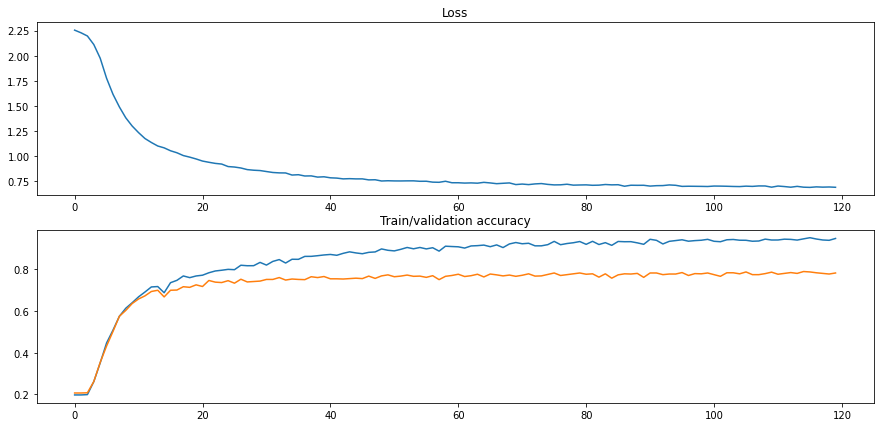

In [34]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [35]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.774000
